Nesse momento, utilizaremos modelos de suavização exponencial, que utilizam pesos exponencialmente decrescentes para observações passadas, priorizando observações mais recentes. Pode ser útil para caso nossos dados mudarem ao longo do tempo, mas com alguma regularidade.

Inicialmente, vamos aplicar um modelo de suavização exponencial simples, e depois seguir para métodos mais avançados como Holt Winters.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents
random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)

In [2]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [3]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)


# Apply Z-Score Normalization
scaler = StandardScaler()
Consumption["Consumption"] = scaler.fit_transform(Consumption[["Consumption"]])

# Ensure it is a Series and set a compatible index (PeriodIndex)
Consumption.index = pd.PeriodIndex(Consumption.index, freq="Q")
Consumption = Consumption["Consumption"]  # Convert to pandas Series

MAE: 0.60
RMSE: 0.63
MASE: 1.55


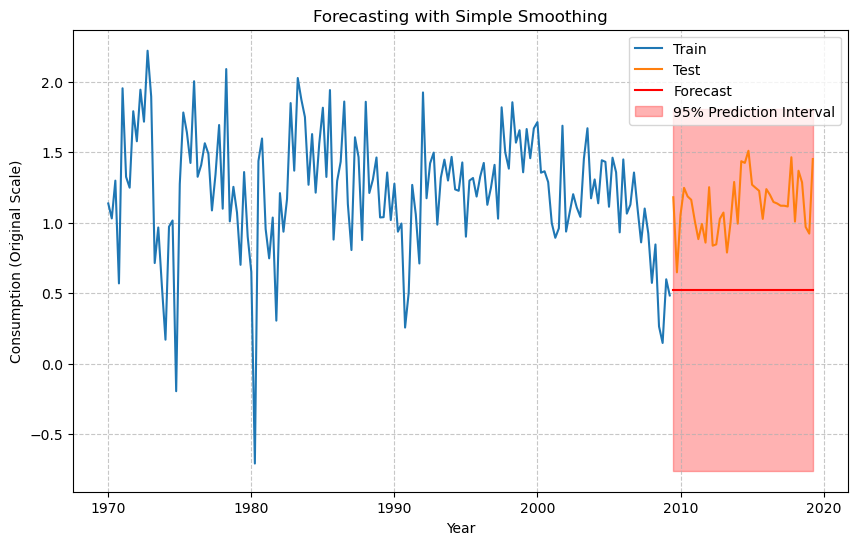

In [7]:
flt = (df["Quarter"] >= "1970Q1") & (df["Quarter"] <= "2019Q2")
Consumption = df[["Quarter", "Consumption"]][flt]
Consumption.set_index("Quarter", inplace=True)


def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

def fit_and_plot_smoothing(dataset, model_type="simple", seasonal="add", trend="add", seasonal_periods=12):
    """
    Function to fit an exponential smoothing strategy and plot the results,
    including the calculation of MAE, RMSE, and MASE.
    """
    # Dividindo o dataset em treino e teste
    train, test = dataset[:-40], dataset[-40:]

    # Escolha do modelo de suavização exponencial
    if model_type == "simple":
        model = SimpleExpSmoothing(train).fit()
    elif model_type == "holt":
        model = ExponentialSmoothing(train, trend=trend).fit()
    elif model_type == "holt_winters":
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    elif model_type == "state_space":
        model = UnobservedComponents(train, level='local level').fit()

    # Previsão
    y_pred = model.forecast(len(test))
    residuals = train - model.fittedvalues
    pred_std = np.std(residuals)  # Desvio padrão dos resíduos
    conf_interval = 1.96 * pred_std  # Intervalo de 95% assumindo normalidade

    # Revertendo dados para a escala original
    y_pred_original = pd.Series(
        scaler.inverse_transform(y_pred.values.reshape(-1, 1)).flatten(),
        index=y_pred.index
    )
    test_original = pd.Series(
        scaler.inverse_transform(test.values.reshape(-1, 1)).flatten(),
        index=test.index
    )
    train_original = pd.Series(
        scaler.inverse_transform(train.values.reshape(-1, 1)).flatten(),
        index=train.index
    )

    # Cálculo de métricas de erro na escala original
    mae = mean_absolute_error(test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(test_original, y_pred_original))
    mase = mean_absolute_scaled_error(test_original, y_pred_original, train_original)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MASE: {mase:.2f}")

    # Plotando série e intervalo de confiança
    plt.figure(figsize=(10, 6))
    plt.plot(train_original.index, train_original, label="Train")
    plt.plot(test_original.index, test_original, label="Test")
    plt.plot(test_original.index, y_pred_original, label="Forecast", color="red")
    plt.fill_between(test_original.index, 
                     y_pred_original - conf_interval, 
                     y_pred_original + conf_interval, 
                     color='red', alpha=0.3, label="95% Prediction Interval")
    plt.legend()
    plt.title(f"Forecasting with {model_type.capitalize()} Smoothing")
    plt.xlabel("Year")
    plt.ylabel("Consumption (Original Scale)")
    plt.grid(linestyle='--', alpha=0.7, zorder=5)
    plt.show()


# Convertendo o índice para formato de data (para garantir compatibilidade)
Consumption.index = pd.to_datetime(Consumption.index.to_timestamp())

# Aplicando os modelos
fit_and_plot_smoothing(Consumption["Consumption"], model_type="simple")



Naturalmente, métodos de suavização exponencial consideram valores mais recentes com peso maior ao estimar predições. Em nosso caso, a série estava vindo de um decaimento alto e esses valores tiveram maior impacto, o que interferiu significativamente nas predições de teste.

MAE: 0.70
RMSE: 0.73
MASE: 1.80


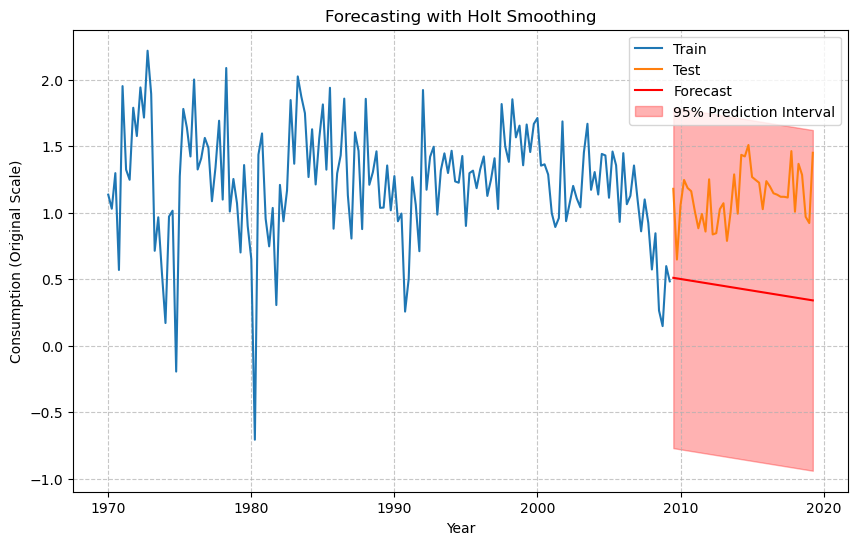

In [8]:
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt", trend="add")

MAE: 0.69
RMSE: 0.73
MASE: 1.77


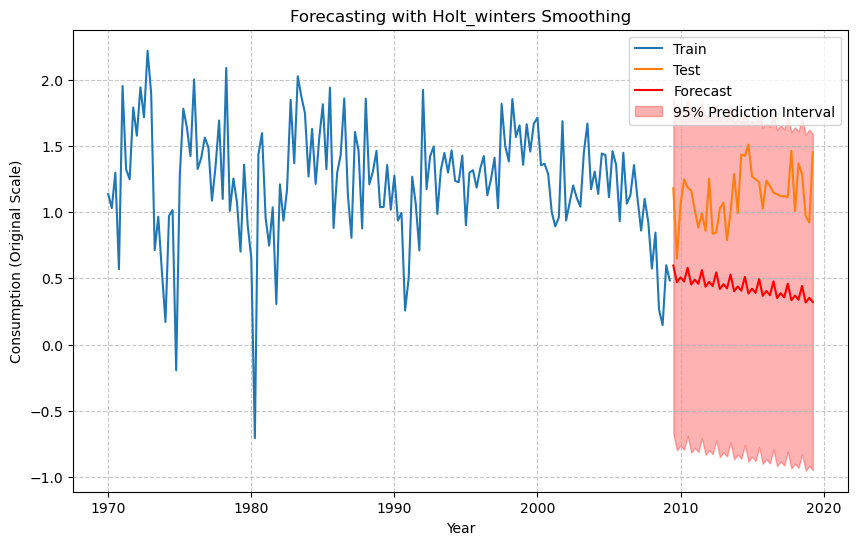

In [9]:
fit_and_plot_smoothing(Consumption["Consumption"], model_type="holt_winters", seasonal="add", seasonal_periods=4)

Os métodos de Holt assumem a tendência e o nível da série temporal. Como discutido anteriormente na sessão de análises, a série não possui uma tendência clara e esses métodos não são os melhores para nossa situação. Portanto, os resultados foram piores até mesmo que a suavização exponencial simples.